## How to run code

#### 1. Declare all classes and common functions
#####      - Classes: Layer, Optimizer, Loss, MLP
#####      - Functions: f1_score (evaluation), mini_batch (use to make batches)
#### 2. Load the train and test data (including split train data into train and validation)
#### 3. Create a model
#### 4. Train a model
#### 5. Make a prediction
#### 6. Evaluate results

In [1]:
# import packages
import numpy as np
from scipy.stats import bernoulli
import pandas as pd
import seaborn as sns
import time

#### Linear Layer, ReLULayer, SoftMaxLayer, BatchNormalizationLayer, DropOutLayer, SigmoidLayer(unused)
## Define Layers

In [2]:
class Layer:

    # abstract class for layers

    def forward(self, x: np.ndarray, train_flag=True):
        pass

    def backward(self, delta: np.ndarray):
        pass

class LinearLayer(Layer):
    # Linear Layer
    # output(y) = input(x) @ w + b

    input: np.ndarray
    output: np.ndarray
    weight: np.ndarray
    bias: np.ndarray
    delta: np.ndarray

    weight_grad: np.ndarray
    bias_grad: np.ndarray

    def __init__(self, input_size, output_size):

        # Randomly assign small values for the weights as the initialization
        self.weight = np.random.uniform(
            # initialization (He) for ReLU, Kaiming_uniform
            high = np.sqrt(6. / input_size),
            low = -np.sqrt(6. / input_size),
            size = (input_size, output_size)
        )

        # Initialize bias, delta
        self.bias = np.zeros(output_size,)
        self.delta = np.zeros(output_size,)

        # Initialize weight_grad, bias_grad
        self.weight_grad = np.zeros((input_size, output_size))
        self.bias_grad = np.zeros(output_size,)

    def forward(self, x:np.ndarray, train_flag=True):
        if not isinstance(x, np.ndarray):
            raise RuntimeError("input x must be a numpy array")

        self.input = x

        # Propagate inputs through the network
        # y = w^t @ x + b = x @ w + b
        self.output = np.dot(x, self.weight) + self.bias

        return self.output

    def backward(self, delta):
        # backward propagation

        # calculate gradient and delta
        self.weight_grad += np.atleast_2d(self.input).T @ np.atleast_2d(delta)
        self.bias_grad += np.sum(delta, axis=0)
        self.delta = delta

        return delta @ self.weight.T

    def update(self, weight, bias):
        # update parameters (wight and bias)
        self.weight = weight
        self.bias = bias

    def zero_grad(self):
        # set gradient to 0
        self.weight_grad.fill(0)
        self.bias_grad.fill(0)

class ReLULayer(Layer):

    # ReLU Layer (Activation)

    def __init__(self):
        # save for backward
        self.out = np.zeros(0)

    def forward(self, x: np.ndarray, train_flag=True):
        # forward propagation
        # input <= 0 then ouput = 0, input > 0 then output = input
        self.out = np.maximum(0, x)
        return self.out

    def backward(self, delta: np.ndarray):
        # backward propagation of ReLU
        return np.where(self.out > 0, 1, 0) * delta

class SoftMaxLayer(Layer):
    # Softmax Layer (Activation)

    def forward(self, x: np.ndarray, train_flag=True):
        exp_x = np.exp(x - np.max(x))
        out = exp_x / np.atleast_2d(np.sum(exp_x, 1)).T
        return out

    def backward(self, delta: np.ndarray):
        # include cross-entropy loss
        return delta

class SigmoidLayer(Layer):

    # Sigmoid Layer (not used)

    def forward(self, x: np.ndarray, train_flag=True):
        return 1 / (1 + np.exp(-x))

    def backward(self, delta: np.ndarray):
        return delta * (1 - delta)

class BatchNormalizationLayer(Layer):
    # Batch Normalization Layer

    def __init__(self, intput_size: int, momentum=0.9, eps=1e-8):

        self.momentum = momentum # for calculating moving average
        self.eps = eps

        self.gamma = np.ones((1, intput_size), dtype="float32")
        self.beta = np.zeros((1, intput_size), dtype="float32")

        self.running_mu = np.zeros(0)
        self.running_var = np.zeros(0)

        # for forward
        self.mu = np.zeros(0)
        self.var = np.zeros(0)
        self.std = np.zeros(0)

        self.x_minus_mu = np.zeros(0)
        self.x_norm = np.zeros(0)

        # for backward
        self.batch_size = None
        self.d_gamma = np.zeros(0)
        self.d_beta = np.zeros(0)

    def update_running_variables(self):

        # update running mu and var, used for prediction
        is_mu_empty = np.array_equal(np.zeros(0), self.running_mu)
        is_var_empty = np.array_equal(np.zeros(0), self.running_var)
        if is_mu_empty != is_var_empty:
            raise ValueError("mean and var should be initialized simultaneously")

        if is_mu_empty:
            self.running_mu = self.mu
            self.running_var = self.var
        else:
            # cannot store all mean & various of batches -> using moving average
            self.running_mu = self.momentum * self.running_mu + (1 - self.momentum) * self.mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var

    def forward(self, x: np.ndarray, train_flag=True):

        if train_flag:
            # if it is training, use batch data to caculate normalized x
            self.mu = np.mean(x, axis=0)
            self.x_minus_mu = x - self.mu
            self.var = np.mean(self.x_minus_mu**2, axis=0)
            self.std = np.sqrt(self.var + self.eps)
            x_norm = self.x_minus_mu / self.std

            self.batch_size = x.shape[0]
            self.x_norm = x_norm

            self.update_running_variables()
        else:
            # if it is not training, use running values to calculate normalized x
            x_minus_mu = x - self.running_mu
            x_norm = x_minus_mu / (np.sqrt(self.running_var + self.eps))

        return self.gamma * x_norm + self.beta

    def backward(self, d_out: np.ndarray) -> np.ndarray:
        # calculate gradient

        self.d_beta = np.sum(d_out, axis=0)
        self.d_gamma = np.sum(d_out * self.x_norm, axis=0)

        d_x_norm = d_out * self.gamma
        d_x_minus_mu1 = d_x_norm / self.std

        d_std = -np.sum((d_x_norm * self.x_minus_mu) / (self.std**2), axis=0)
        d_var = 0.5 * d_std / self.std

        d_x_minus_mu2 = (2 / self.batch_size) * self.x_minus_mu * d_var

        d_x1 = d_x_minus_mu1 + d_x_minus_mu2

        d_mu = -1 * np.sum(d_x_minus_mu1 + d_x_minus_mu2, axis=0)
        d_x2 = d_mu  / self.batch_size

        d_x = d_x1 + d_x2

        return d_x

    def update(self, learning_rate):
        # update parameters (gamma, beta)
        self.gamma -= learning_rate * self.d_gamma
        self.beta -= learning_rate * self.d_beta

    def zero_grad(self):
        # set gradient to 0
        self.d_gamma.fill(0)
        self.d_beta.fill(0)

class DropOutLayer(Layer):
    # Dropout Layer
    # Dropout neurons using bernoulli random variable

    def __init__(self, dropout_ratio=0.6):
        self.mask = None
        self.present_ratio = 1.0 - dropout_ratio

    def forward(self, x, train_flag=True):
        if train_flag:
            # if it is training, do droupout

            # dropout using bernoulli random variable
            self.mask = (bernoulli.rvs(size=x.shape[0] * x.shape[1], p=self.present_ratio)).reshape(*x.shape)

            # weights are scaled-up by a factor of 1/𝑝, present with probability p, p = 1 - dropout_ratio
            return x * self.mask / self.present_ratio
        else:
            # if it is not training, do not droupout
            return x * self.present_ratio

    def backward(self, dout):
        # also drop and scale up in backward propagation
        return dout * self.mask / self.present_ratio

## Define Optimizers
#### SGD, Momentum (with weight decay), Adam (with weight decay)

In [3]:
class Optimizer:

    # Optimizer Layer
    # step(): update parameters
    # zero_grad: initialize gradient to zero

    def __init__(self, model):

        if not isinstance(model, MLP):
            raise RuntimeError("Use only MLP model")

        self.model = model

        return

    def zero_grad(self):
        pass

    def step(self):
        pass

class SGD(Optimizer):
    # Stochastic Gradient Descent (not used)

    learning_rate: float

    def __init__(self, model, learning_rate=0.1):
        super(SGD, self).__init__(model)
        self.learning_rate = learning_rate

    def step(self):
        # update parameters
        for layer in self.model.hidden_layers:
            # update parameters, θ = θ - η * gradient
            weight = layer.weight - self.learning_rate * layer.weight_grad
            bias = layer.bias - self.learning_rate * layer.bias_grad
            layer.update(weight, bias)

    def zero_grad(self):
        # set gradient to 0
        for layer in self.model.hidden_layers:
            if isinstance(layer, LinearLayer) or isinstance(layer, BatchNormalizationLayer):
                layer.zero_grad()
        return

class Momentum(Optimizer):
    # Momentum Optimizer

    def __init__(self, model, learning_rate=0.1, momentum=0.9, weight_decay=0):
        super(Momentum, self).__init__(model)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay

        # initialize v_t
        self.v = []
        for layer in self.model.hidden_layers:
            # A Optimizer works for only Linear Layer
            if isinstance(layer, LinearLayer):
                self.v.append({'weight': np.zeros_like(layer.weight), 'bias': np.zeros_like(layer.bias)})
            else:
                self.v.append(None)

        return

    def step(self):
        for idx, layer in enumerate(self.model.hidden_layers):
            if isinstance(layer, LinearLayer):
                # update parameters of linear layer (weight, bias)

                # compute v_t of weight and bias, v_t = γ * v_t-1 + η * gradient
                self.v[idx]['weight'] = self.momentum * self.v[idx]['weight'] + self.learning_rate * layer.weight_grad
                self.v[idx]['bias'] = self.momentum * self.v[idx]['bias'] + self.learning_rate * layer.bias

                # update network, θ = θ - v_t
                # weight decay: θ = (1 - ηα) * θ - η * gradient = (1 - ηα) * θ - v_t
                weight = (1 - self.learning_rate * self.weight_decay) * layer.weight - self.v[idx]['weight']
                bias = (1 - self.learning_rate * self.weight_decay) * layer.bias - self.v[idx]['bias']

                layer.update(weight, bias)

            if isinstance(layer, BatchNormalizationLayer):
                # update parameters of BatchNormalization layer (gamma, beta)
                layer.update(self.learning_rate)

    def zero_grad(self):
        # initialize gradient
        for layer in self.model.hidden_layers:
            if isinstance(layer, LinearLayer) or isinstance(layer, BatchNormalizationLayer):
                layer.zero_grad()

        # initialize v
        for v in self.v:
            if not v is None:
                v['weight'].fill(0)
                v['bias'].fill(0)

        return

class Adam(Optimizer):
    # ADAM(adaptive moment estimation) Optimizer

    def __init__(self, model, learning_rate, beta1=0.9, beta2=0.999, weight_decay=0, eps=1e-08):
        super(Adam, self).__init__(model)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # initialize m, v, t
        self.m = []
        self.v = []
        self.t = []

        for layer in self.model.hidden_layers:
            # A Optimizer works for only Linear Layer
            if isinstance(layer, LinearLayer):
                self.m.append({'weight': np.zeros_like(layer.weight), 'bias': np.zeros_like(layer.bias)})
                self.v.append({'weight': np.zeros_like(layer.weight), 'bias': np.zeros_like(layer.bias)})
                self.t.append(1)
            else:
                self.m.append(None)
                self.v.append(None)
                self.t.append(None)

    def step(self):
        # update parameters
        # (weight, bias) for linear, (gamma, beta) for batch normalization

        for idx, layer in enumerate(self.model.hidden_layers):
            if isinstance(layer, LinearLayer):
                # update weight and bias
                m_hat = {}
                v_hat = {}

                # calculate m_t, m_t_hat for weight
                self.m[idx]['weight'] = self.beta1 * self.m[idx]['weight'] + (1 - self.beta1) * layer.weight_grad
                self.v[idx]['weight'] = self.beta2 * self.v[idx]['weight'] + (1 - self.beta2) * layer.weight_grad**2
                m_hat['weight'] = self.m[idx]['weight'] / (1 - self.beta1**self.t[idx])
                v_hat['weight'] = self.v[idx]['weight'] / (1 - self.beta2**self.t[idx])
                # calculate m_t, m_t_hat for bias
                self.m[idx]['bias'] = self.beta1 * self.m[idx]['bias'] + (1 - self.beta1) * layer.bias_grad
                self.v[idx]['bias'] = self.beta2 * self.v[idx]['bias'] + (1 - self.beta2) * layer.bias_grad**2
                m_hat['bias'] = self.m[idx]['bias'] / (1 - self.beta1**self.t[idx])
                v_hat['bias'] = self.v[idx]['bias'] / (1 - self.beta2**self.t[idx])

                # calculate gradient
                # update network, θ = θ - η * m_t / sqrt(v_t + e)
                # weight decay: θ = (1 - ηα) * θ - η * gradient = (1 - ηα) * θ - η * m_t / sqrt(v_t + e)
                grad_weight = m_hat['weight'] / np.sqrt(v_hat['weight'] + self.eps)
                grad_bias = m_hat['bias'] / np.sqrt(v_hat['bias'] + self.eps)

                # gradient clipping for weight and bias
                norm_weight = np.linalg.norm(grad_weight)
                if norm_weight > 1.0:
                    grad_weight = grad_weight * (1.0 / norm_weight)
                norm_bias = np.linalg.norm(grad_weight)
                if norm_bias > 1.0:
                    grad_weight = grad_weight * (1.0 / norm_bias)

                # update weight and bias of linear layer
                weight = (1 - self.learning_rate * self.weight_decay) * layer.weight - self.learning_rate * grad_weight
                bias = (1 - self.learning_rate * self.weight_decay) * layer.bias - self.learning_rate * grad_bias
                layer.update(weight, bias)

                self.t[idx] += 1

            if isinstance(layer, BatchNormalizationLayer):
                # update gamma and beta of batch normalization layer
                layer.update(self.learning_rate)

    def zero_grad(self):
        # initialize gradients of layers
        for layer in self.model.hidden_layers:
            if isinstance(layer, LinearLayer) or isinstance(layer, BatchNormalizationLayer):
                layer.zero_grad()

        # initialize m, v, t
        for i in range(len(self.m)):
            if not self.m[i] is None:
                self.m[i]['weight'].fill(0)
                self.m[i]['bias'].fill(0)

            if not self.v[i] is None:
                self.v[i]['weight'].fill(0)
                self.v[i]['bias'].fill(0)

            self.t[i] = 1

## Define
#### Cross-Entropy Loss

In [4]:
class Loss:
    # class for loss function

    loss: int
    delta: np.ndarray

    def __init__(self, model):
        if not isinstance(model, MLP):
            raise RuntimeError("Use only MLP model")

        self.model = model
        return

    def backward(self):
        self.model.backward(self.delta)

class CrossEntropyLoss(Loss):
    # Cross-Entropy Loss
    # Backward propagation includes softmax for computing efficiency, delta = y_hat - y

    def __init__(self, model, y_hat, y, is_one_hot=False, eps=1e-8):
        super(CrossEntropyLoss, self).__init__(model)
        self.eps = eps

        if is_one_hot:
            # if format of y is one-hot encoding
            # compute loss
            self.loss = -np.sum(y * np.log(y_hat + self.eps)) / (y.shape[0])

            # Compute delta of output layer
            self.delta = y_hat - y
            self.delta /= np.atleast_2d(y_hat).shape[0]
        else:
            # if format of y is not one-hot encoding
            if y_hat.ndim ==1:
                y_hat = np.atleast_2d(y_hat)
                y = np.atleast_2d(y)
            # compute loss
            self.loss = -np.sum(np.log(y_hat[np.arange(y_hat.shape[0]),y] + self.eps)) / y_hat.shape[0]

            # Compute delta of output layer (for softmax cross-entropy: y_hat - y)
            # actual y value is always 0 or 1, but y value in this function has a label value between 0 and 9 (not one-hot encoding)
            # so, use y as an index and subtract 1 from y_hat[y].
            self.delta = np.copy(y_hat)
            self.delta[np.arange(y_hat.shape[0]), y] -= 1
            self.delta /= np.atleast_2d(y_hat).shape[0]

        return

    def get_loss(self):
        # return loss
        return self.loss

## Define Multi Layer Perceptron Class

In [5]:
# MLP model
class MLP:
    # class for Multi Layer Perceptron Model

    hidden_layers: list # e.g. linear, activation, batch normalization, dropout
    parameters: list # for model saving and loading during early stopping in training

    def __init__(self, layers: list):
        self.hidden_layers = layers
        self.parameters = []
        return

    def forward(self, x, train_flag=True):
        # forward propagate inputs through the network
        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i].forward(x, train_flag=train_flag)

        return x

    def backward(self, delta):
        # backward propagation
        for i in reversed(range(len(self.hidden_layers))):
            delta = self.hidden_layers[i].backward(delta)

    def train(self, x_train:np.ndarray, y_train:np.ndarray, x_valid:np.ndarray, y_valid:np.ndarray, epochs=100,
              optimizer='momentum', learning_rate=0.001, momentum=0, weight_decay=0, patience=15, verbose=2):
        # train a model

        loss_fn = CrossEntropyLoss # set loss function
        batch_size = 32 # set batch size
        n_batch = int(np.ceil(x_train.shape[0]/batch_size)) # calculate a number of batches

        # set a optimizer according to input
        if optimizer == 'momentum':
            optimizer = Momentum(model=self, learning_rate=learning_rate, momentum=momentum)
        elif optimizer == 'adam':
            optimizer = Adam(model=self, learning_rate=learning_rate)
        else:
            optimizer = SGD(model=self, learning_rate=learning_rate)

        # initialize values for training
        patience_cnt = 0
        best_train_loss = 9999
        best_train_acc = 0
        best_valid_loss = 9999
        best_valid_acc = 0
        best_epoch = 0

        for epoch in range(1, epochs+1):

            loss_sum = 0    # use to calculate total loss, loss = loss_sum / batch_size
            match_cnt = 0   # use to calculate accuracy, accuracy = match_cnt / # of total
            start_time = time.time() # use to caculate runtime for each epoch

            for x_batch, y_batch in iterate_mini_batch(x_train, y_train, batch_size, shuffle=True):

                y_hat = self.forward(x_batch, train_flag=True) # forward
                loss = loss_fn(self, y_hat, y_batch) # loss
                loss_sum += loss.get_loss() # add loss
                match_cnt += np.sum((y_hat.argmax(1)==y_batch)) # add a number of correct y_hat
                loss.backward() # backward

                optimizer.step() # update parameters
                optimizer.zero_grad() # initialize gradients

            # stop if the model does not get better, compare to validation
            y_hat_valid = self.predict(x_valid) # predict using validation data set

            # calculate current loss and accuracy of train and validation
            curr_train_loss = loss_sum / n_batch
            curr_train_acc = match_cnt / y_train.shape[0]
            curr_valid_loss = loss_fn(self, y_hat_valid, y_valid).get_loss()
            curr_valid_acc = np.mean(y_hat_valid.argmax(1)==y_valid)

            if curr_valid_loss >= best_valid_loss:
                # if the loss increases (the models' performance decreases)
                patience_cnt += 1

                if patience_cnt > patience:
                    # if the performance does not improve for some time, early stopping
                    if verbose >= 2:
                        print('epoch {:}, early stopping'.format(epoch))

                    self.load_parameters() # load parameters of the best model
                    break

            else:
                # store information of the best model
                best_epoch = epoch
                best_train_loss = curr_train_loss
                best_train_acc = curr_train_acc
                best_valid_loss = curr_valid_loss
                best_valid_acc = curr_valid_acc

                patience_cnt = 0 # initialize patience count
                self.save_parameters() # save parameters of the best model

            end_time = time.time() # use to caculate runtime for each epoch

            if verbose >= 2:
                # print result of each epoch
                print("epoch {:}: train_ce_Loss={:.8f}, train_acc={:.8f}, valid_ce_loss={:.8f}, valid_acc={:.8f}, patience={:}, runtime: {:.4f}".format(epoch, curr_train_loss, curr_train_acc, curr_valid_loss, curr_valid_acc, patience_cnt, end_time-start_time))

        if verbose >= 1:
            # print result of the best epoch
            print('best at epoch {:}, train_loss: {:.8f}, train_acc: {:.8f}, valid_loss: {:.8f}, valid_acc: {:.8f}'.format(best_epoch, best_train_loss, best_train_acc, best_valid_loss, best_valid_acc))

    def predict(self, x):
        # make a prediction
        if not isinstance(x, np.ndarray):
            raise RuntimeError("input x must be a numpy array")

        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i].forward(x, train_flag=False)

        return x

    def save_parameters(self):
        # save parameters for early stopping
        self.parameters = []
        for layer in self.hidden_layers:
            if isinstance(layer, LinearLayer):
                self.parameters.append({'weight': layer.weight, 'bias': layer.bias})
            elif isinstance(layer, BatchNormalizationLayer):
                self.parameters.append({'gamma': layer.gamma, 'beta': layer.beta, 'running_mu': layer.running_mu, 'running_var': layer.running_var})
            else:
                self.parameters.append(None)

    def load_parameters(self):
        # load parameters for early stopping
        for idx, layer in enumerate(self.hidden_layers):
            if isinstance(layer, LinearLayer):
                layer.weight = self.parameters[idx]['weight']
                layer.bias = self.parameters[idx]['bias']
            elif isinstance(layer, BatchNormalizationLayer):
                layer.gamma = self.parameters[idx]['gamma']
                layer.beta = self.parameters[idx]['beta']
                layer.running_mu = self.parameters[idx]['running_mu']
                layer.running_var = self.parameters[idx]['running_var']


## Functions for evaluation

In [6]:
def f1_score(actual, predicted, label=1):
    # F1 = 2 * (precision * recall) / (precision + recall)

    tp = np.sum((actual==label) & (predicted==label))
    fp = np.sum((actual!=label) & (predicted==label))
    fn = np.sum((predicted!=label) & (actual==label))

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

## Function for mini batch

In [7]:
def iterate_mini_batch(x, y, batch_size, shuffle=True, replace=False):
    assert x.shape[0] == y.shape[0]

    if shuffle:

        if replace:
            # Randomly choose and allow replacement
            for i in range(0, x.shape[0], batch_size):
                idx_rand = np.random.choice(x.shape[0], min(batch_size, x.shape[0] - i))
                yield x[idx_rand], y[idx_rand]
        else:
            # Shuffle and do not allow replacement
            indexes = np.arange(x.shape[0])
            np.random.shuffle(indexes)

            for i in range(0, x.shape[0], batch_size):
                yield x[indexes[i:min(i+batch_size, x.shape[0])]], y[indexes[i:min(i+batch_size, x.shape[0])]]

    else:
        # Do not Shuffle
        for i in range(0, x.shape[0], batch_size):
            yield x[i:min(i+batch_size, x.shape[0])], y[i:min(i+batch_size, x.shape[0])]

## Load train and test data
#### split train data into train data and validation data (8:2)

In [8]:
x_train = np.load('./train_data.npy')
y_train = np.load('./train_label.npy')
x_test = np.load('./test_data.npy')
y_test = np.load('./test_label.npy')

# split train dataset into train dataset and validation dataset
temp_idx = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
n_valid = int(x_train.shape[0] * 0.2)
valid_mask = temp_idx[:n_valid]
train_mask = temp_idx[n_valid:]

x_valid = x_train[valid_mask]
y_valid = y_train[valid_mask]
x_train = x_train[train_mask]
y_train = y_train[train_mask]

# print shapes
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(40000, 128) (10000, 128) (40000, 1) (10000, 1)
(10000, 128) (10000, 1)


## Train, predict and evaluate of the best model

In [9]:
# create a model
myMLP = MLP(layers=[LinearLayer(128,200),
                    BatchNormalizationLayer(200),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(200,200),
                    BatchNormalizationLayer(200),
                    ReLULayer(),
                    DropOutLayer(dropout_ratio=0.1),
                    LinearLayer(200,10),
                    SoftMaxLayer()])

start_train = time.time() # set start time of train

# train and test the model
myMLP.train(x_train=x_train, y_train=y_train.flatten(), x_valid=x_valid, y_valid=y_valid.flatten(),
            optimizer="momentum", learning_rate=0.1, weight_decay=0.1, patience=15, verbose=3)

end_train = time.time() # set end time of train

start_test = time.time() # set start time of test
# predict on test dataset and print result
pred = myMLP.predict(x_test)
end_test = time.time() # set end time of test
print('loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}'.format(
    CrossEntropyLoss(myMLP, pred, y_test.flatten()).get_loss(),
    np.mean(pred.argmax(1) == y_test.flatten()),
    f1_score(y_test.flatten(), pred.argmax(1))))

# print a total runtime
print(f"train run-time: {end_train - start_train:.4f} sec")
print(f"test run-time: {end_test - start_test:.4f} sec")

epoch 1: train_ce_Loss=1.76860592, train_acc=0.36867500, valid_ce_loss=1.60266916, valid_acc=0.42560000, patience=0, runtime: 7.5424
epoch 2: train_ce_Loss=1.57467236, train_acc=0.43537500, valid_ce_loss=1.52273499, valid_acc=0.44720000, patience=0, runtime: 7.6398
epoch 3: train_ce_Loss=1.50791591, train_acc=0.46142500, valid_ce_loss=1.44400581, valid_acc=0.48360000, patience=0, runtime: 7.6623
epoch 4: train_ce_Loss=1.45360495, train_acc=0.47987500, valid_ce_loss=1.43050036, valid_acc=0.48760000, patience=0, runtime: 7.5293
epoch 5: train_ce_Loss=1.41033781, train_acc=0.49807500, valid_ce_loss=1.39068876, valid_acc=0.49680000, patience=0, runtime: 7.7547
epoch 6: train_ce_Loss=1.37774376, train_acc=0.50990000, valid_ce_loss=1.37251884, valid_acc=0.51250000, patience=0, runtime: 7.7209
epoch 7: train_ce_Loss=1.34734723, train_acc=0.51922500, valid_ce_loss=1.35265577, valid_acc=0.51900000, patience=0, runtime: 8.0368
epoch 8: train_ce_Loss=1.32966004, train_acc=0.52342500, valid_ce_los

In [10]:
pred = myMLP.predict(x_test)
y_actu = pd.Series(y_test.reshape(y_test.shape[0]), name='Actual')
y_pred = pd.Series(pred.argmax(1), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")
df_confusion_norm

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,0.655,0.019,0.078,0.013,0.028,0.015,0.039,0.013,0.104,0.036
1,0.049,0.652,0.021,0.014,0.017,0.008,0.027,0.016,0.077,0.119
2,0.072,0.013,0.443,0.066,0.163,0.041,0.119,0.054,0.022,0.007
3,0.026,0.019,0.100,0.312,0.087,0.159,0.188,0.060,0.020,0.029
4,0.047,0.007,0.155,0.033,0.504,0.027,0.122,0.074,0.024,0.007
5,0.023,0.004,0.099,0.179,0.070,0.376,0.126,0.087,0.018,0.018
6,0.006,0.011,0.083,0.051,0.124,0.018,0.669,0.014,0.012,0.012
7,0.042,0.010,0.047,0.043,0.100,0.062,0.034,0.625,0.009,0.028
8,0.114,0.054,0.026,0.020,0.021,0.006,0.019,0.016,0.687,0.037


<Axes: xlabel='Predicted', ylabel='Actual'>

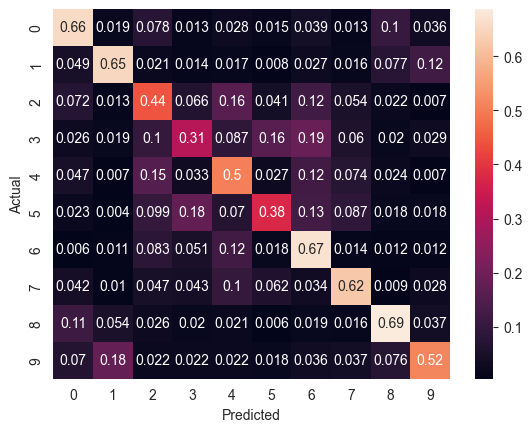

In [11]:
sns.heatmap(df_confusion_norm, annot=True)